<a href="https://colab.research.google.com/github/HarisGunawanRomadon/text-to-image-transformer-model/blob/main/text_to_image_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install datasets diffusers transformers accelerate

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

# 1. Load Dataset
print("Memuat dataset...")
raw_dataset = load_dataset("reach-vb/pokemon-blip-captions", split="train")

# 2. Ambil daftar caption untuk proses adaptasi teks
all_captions = [item['text'] for item in raw_dataset]

Memuat dataset...


In [26]:
# 3. Setup Text Vectorization
max_tokens = 5000
seq_len = 20

text_vectorizer = layers.TextVectorization(
  max_tokens=max_tokens,
  output_sequence_length=seq_len,
)

# Proses Adapt (Mempelajari kosakata dari dataset)
text_vectorizer.adapt(all_captions)
vocab = text_vectorizer.get_vocabulary()
print(f"Kamus Teks Berhasil Dibuat. Jumlah kosakata: {len(vocab)}")
print("Contoh 10 kata pertama:", vocab[:10])

Kamus Teks Berhasil Dibuat. Jumlah kosakata: 359
Contoh 10 kata pertama: ['', '[UNK]', np.str_('a'), np.str_('with'), np.str_('of'), np.str_('cartoon'), np.str_('and'), np.str_('drawing'), np.str_('character'), np.str_('on')]


In [30]:
def preprocess_fn(item):
  # Proses Gambar
  image = item['image'].convert("RGB").resize((64, 64))
  image = np.array(image) / 255.0 # Normalisasi 0-1
  # Proses Teks
  caption = item['text']
  return caption, image

# Membuat generator dataset
def gen():
  for item in raw_dataset:
    yield preprocess_fn(item)
    # Membuat tf.data.Dataset
train_ds = tf.data.Dataset.from_generator(
gen,
output_signature=(
  tf.TensorSpec(shape=(), dtype=tf.string),
  tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float32)
  )
)

  # Batching dan Transformasi Teks ke Angka
train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y))
train_ds = train_ds.batch(16).shuffle(100).prefetch(tf.data.AUTOTUNE)

In [31]:
# 1. Konfigurasi Hyperparameter
text_vocab_size = len(vocab) # Dari vectorizer Anda (sekitar 3000-5000)
visual_vocab_size = 1024     # Ukuran codebook VQVAE (biasanya 1024 atau 16384)
embed_dim = 256              # Dimensi embedding
num_heads = 4
ff_dim = 512
visual_seq_len = 256         # Panjang urutan token gambar (16x16 = 256) -> Asumsi grid 16x16
text_seq_len = 20            # Dari setting Anda sebelumnya

# 2. Membuat Arsitektur Transformer Sederhana
def create_transformer(text_vocab, vis_vocab, txt_len, vis_len, embed_dim, heads, ff_dim):
    # Input Teks dan Visual
    txt_input = layers.Input(shape=(txt_len,), dtype=tf.int64, name='text_input')
    vis_input = layers.Input(shape=(vis_len-1,), dtype=tf.int64, name='visual_input') # -1 karena autoregressive

    # Embedding
    txt_emb = layers.Embedding(text_vocab, embed_dim)(txt_input)
    vis_emb = layers.Embedding(vis_vocab, embed_dim)(vis_input)

    # Positional Encoding (Simpel: pakai Embedding layer sebagai posisi)
    # Catatan: Ini versi simplifikasi agar kode jalan
    pos_emb_txt = layers.Embedding(txt_len, embed_dim)(tf.range(txt_len))
    pos_emb_vis = layers.Embedding(vis_len-1, embed_dim)(tf.range(vis_len-1))

    x_txt = txt_emb + pos_emb_txt
    x_vis = vis_emb + pos_emb_vis

    # Gabungkan (Concatenate) Teks dan Visual
    x = layers.Concatenate(axis=1)([x_txt, x_vis])

    # Transformer Block (Minimalis)
    # Self Attention
    attn_output = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)(x, x)
    x = layers.LayerNormalization()(x + attn_output)

    # Feed Forward
    ff_output = layers.Dense(ff_dim, activation="relu")(x)
    ff_output = layers.Dense(embed_dim)(ff_output)
    x = layers.LayerNormalization()(x + ff_output)

    # Output Layer
    # Kita ingin memprediksi token visual berikutnya
    # Output harus sesuai dengan vocab visual
    outputs = layers.Dense(vis_vocab)(x)

    # Karena input gabungan (text + vis), outputnya akan sepanjang (text + vis).
    # Kita hanya butuh bagian visual untuk loss calculation.
    # Ambil bagian belakang sesuai panjang visual input
    visual_outputs = outputs[:, txt_len:, :]

    return keras.Model(inputs=[txt_input, vis_input], outputs=visual_outputs)

# 3. Inisialisasi Model Transformer
transformer_model = create_transformer(
    text_vocab=text_vocab_size,
    vis_vocab=visual_vocab_size,
    txt_len=text_seq_len,
    vis_len=visual_seq_len,
    embed_dim=embed_dim,
    heads=num_heads,
    ff_dim=ff_dim
)

# 4. Dummy VQVAE Encoder
# Karena di 'train_step' Anda menggunakan tf.random.uniform (simulasi),
# kita bisa buat dummy object saja untuk menghindari NameError pada vqvae_encoder.
class DummyVQVAE:
    pass

vqvae_encoder = DummyVQVAE()

print("Model Transformer berhasil dibuat!")
transformer_model.summary()

class PokemonTrainer(keras.Model):
  def __init__(self, transformer, vqvae_encoder):
    super().__init__()
    self.transformer = transformer
    self.vqvae_encoder = vqvae_encoder
    self.loss_tracker = keras.metrics.Mean(name="loss")

  def train_step(self, data):
    text_tokens, images = data

    # 1. Ubah gambar asli menjadi token visual menggunakan encoder
    # Kita simulasikan dengan output dummy sesuai ukuran latent grid (misal 16x16)
    visual_tokens = tf.random.uniform((tf.shape(images)[0], 256), minval=0, maxval=1024, dtype=tf.int32)

    # 2. Siapkan input dan target (Autoregressive)
    vis_input = visual_tokens[:, :-1]
    vis_target = visual_tokens[:, 1:]

    with tf.GradientTape() as tape:
      # Prediksi
      preds = self.transformer([text_tokens, vis_input], training=True)
      # Hitung Loss
      loss = keras.losses.sparse_categorical_crossentropy(vis_target, preds, from_logits=True)

    grads = tape.gradient(loss, self.transformer.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, self.transformer.trainable_variables))

    self.loss_tracker.update_state(loss)
    return {"loss": self.loss_tracker.result()}

# Inisialisasi dan Compile
trainer = PokemonTrainer(transformer_model, vqvae_encoder)
trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

# 5. Jalankan Training
print("Memulai Pelatihan...")
# Note: Pastikan `train_ds` sudah di-run dari blok kode Anda sebelumnya
trainer.fit(train_ds, epochs=10)

Model Transformer berhasil dibuat!


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ visual_input        │ (None, 255)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_23        │ (None, 20, 256)   │     91,904 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_24        │ (None, 255, 256)  │    262,144 │ visual_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 20, 256)   │          0 │ embedding_23[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 255, 256)  │          0 │ embedding_24[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 275, 256)  │          0 │ add_20[0][0],     │
│ (Concatenate)       │                   │            │ add_21[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 275, 256)  │  1,051,904 │ concatenate_5[0]… │
│ (MultiHeadAttentio… │                   │            │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 275, 256)  │          0 │ concatenate_5[0]… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 275, 256)  │        512 │ add_22[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 275, 512)  │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_49 (Dense)    │ (None, 275, 256)  │    131,328 │ dense_48[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_23 (Add)        │ (None, 275, 256)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_49[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 275, 256)  │        512 │ add_23[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 275, 1024) │    263,168 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 255, 1024) │          0 │ dense_50[0][0]    │
│ (GetItem)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,933,056 (7.37 MB)

 Trainable params: 1,933,056 (7.37 MB)

 Non-trainable params: 0 (0.00 B)

Memulai Pelatihan...
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 88ms/step - loss: 7.1193
Epoch 2/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 7.0118
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 6.9398
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 6.9366
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 6.9356
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 6.9355
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 6.9348
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - loss: 6.9348
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 6.9345
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - loss: 6.9347


Memuat VQVAE Decoder...


An error occurred while trying to fetch CompVis/ldm-super-resolution-4x-openimages: CompVis/ldm-super-resolution-4x-openimages does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Prompt: 'a orange cat'
Sedang meng-generate token visual......... Selesai!
Mendecode vector shape torch.Size([1, 3, 16, 16]) ke gambar...


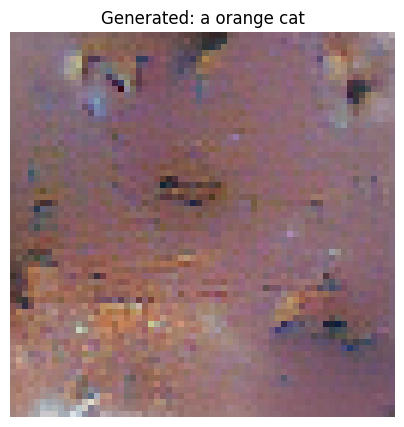

In [43]:
from diffusers import VQModel
import torch

def generate_image_tokens(model, text_tokens, max_len=256, vocab_size=1024):
    # Mulai dengan token awal (Start Token)
    curr_vis_tokens = tf.zeros((1, 1), dtype=tf.int64)

    print("Sedang meng-generate token visual...", end="")

    # Loop sebanyak target (256 kali)
    for i in range(max_len):
        current_seq_len = tf.shape(curr_vis_tokens)[1]

        # LOGIKA BARU: Sliding Window & Padding
        # Model transformer kita menerima input visual FIXED length (255 token)

        if current_seq_len < 255:
            # Jika token masih sedikit, lakukan Padding di kanan
            pad_len = 255 - current_seq_len
            vis_input = tf.pad(curr_vis_tokens, [[0, 0], [0, pad_len]])
        else:
            # Jika token sudah banyak, AMBIL 255 TOKEN TERAKHIR (Sliding Window)
            # Ini kuncinya agar kita bisa generate token ke-256
            vis_input = curr_vis_tokens[:, -255:]

        # Prediksi
        predictions = model([text_tokens, vis_input], training=False)

        # Ambil logits dari posisi terakhir yang valid
        # Karena kita melakukan padding/sliding, token yang kita prediksi selalu
        # berada di posisi (current_seq_len - 1) jika belum penuh,
        # atau di posisi terakhir (254) jika sudah penuh.

        idx_to_predict = tf.minimum(current_seq_len - 1, 254)
        logits = predictions[:, idx_to_predict, :]

        # Sampling
        next_token = tf.random.categorical(logits, num_samples=1)
        next_token = tf.cast(next_token, tf.int64)

        # Gabungkan
        curr_vis_tokens = tf.concat([curr_vis_tokens, next_token], axis=1)

        if i % 50 == 0: print(".", end="")

    print(" Selesai!")

    # Hapus token awal (dummy 0) dan pastikan panjangnya pas 256
    result = curr_vis_tokens[:, 1:]

    # Safety Check: Jika karena suatu hal hasilnya lebih, potong jadi 256
    return result[:, :256]

# 1. Load Model (Ini sudah berhasil di langkah Anda sebelumnya)
# Kita gunakan try-except untuk menangani fallback otomatis
print("Memuat VQVAE Decoder...")
try:
    # Coba model utama
    vqvae = VQModel.from_pretrained("CompVis/ldm-super-resolution-4x-openimages", subfolder="vqvae")
except:
    # Fallback ke model alternatif jika yang diatas bermasalah
    vqvae = VQModel.from_pretrained("CompVis/vqgan_imagenet_f16_16384", subfolder="vqvae")

vqvae.to("cpu")

def decode_to_real_image(tokens):
    # tokens shape: (1, 256)

    # 1. Konversi ke Torch Tensor
    tokens_tensor = torch.tensor(tokens.numpy(), dtype=torch.long) # Shape: (1, 256)

    # 2. Dapatkan ukuran embedding otomatis dari model yang didownload
    # Ini kuncinya agar tidak error "invalid shape"
    # Model 'ldm' biasanya punya latent_channels=3, sedangkan yang lain 256.
    embed_dim = vqvae.config.latent_channels

    # 3. Ambil vektor dari codebook
    # Kita flatten dulu indices-nya agar mudah diambil
    flat_indices = tokens_tensor.flatten()

    # Ambil vektor (embedding) berdasarkan index
    # Hasilnya akan berukuran: (Batch*Seq_Len, embed_dim) -> (256, 3)
    embedding = vqvae.quantize.get_codebook_entry(flat_indices, shape=None)

    # 4. Reshape sesuai grid 16x16
    # Ubah dari (256, embed_dim) menjadi (1, 16, 16, embed_dim)
    embedding = embedding.reshape(1, 16, 16, embed_dim)

    # 5. Permute agar sesuai format PyTorch (Batch, Channel, Height, Width)
    # Dari (1, 16, 16, 3) -> (1, 3, 16, 16)
    embedding = embedding.permute(0, 3, 1, 2)

    # 6. Decode ke Gambar
    print(f"Mendecode vector shape {embedding.shape} ke gambar...")
    with torch.no_grad():
        decoded_image = vqvae.decode(embedding, force_not_quantize=True).sample

    # 7. Normalisasi dan Konversi ke Numpy
    decoded_image = (decoded_image / 2.0 + 0.5).clamp(0, 1)
    decoded_image = decoded_image.cpu().permute(0, 2, 3, 1).numpy()

    return decoded_image[0]

# --- FUNGSI GENERATE (Tidak berubah, hanya dipanggil ulang) ---
def generate_pokemon(prompt):
    print(f"Prompt: '{prompt}'")
    tokenized_text = text_vectorizer([prompt])

    # Generate token
    gen_vis_tokens = generate_image_tokens(transformer_model, tokenized_text, max_len=256)

    # Decode (Sekarang aman dari error shape)
    final_image = decode_to_real_image(gen_vis_tokens)

    plt.figure(figsize=(5,5))
    plt.imshow(final_image)
    plt.title(f"Generated: {prompt}")
    plt.axis("off")
    plt.show()

# Run
generate_pokemon("a orange cat")